Please refer to my [Medium article](https://medium.com/@fernandopalominocobo/mastering-u-net-a-step-by-step-guide-to-segmentation-from-scratch-with-pytorch-6a17c5916114) for code explanations!!

# Load the required libraries

In [ ]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

# U-Net architecture

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


In [3]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [4]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out


In [6]:
input_image = torch.rand((1,3,512,512))
model = UNet(3,10)
output = model(input_image)
print(output.size())
# You should get torch.Size([1, 10, 512, 512]) as a result

torch.Size([1, 10, 512, 512])


# Load the Carvana Dataset

In [7]:
class CarvanaDataset(Dataset):
    def __init__(self, root_path, limit=None):
        self.root_path = root_path
        self.limit = limit
        self.images = sorted([root_path + "/train/" + i for i in os.listdir(root_path + "/train/")])[:self.limit]
        self.masks = sorted([root_path + "/train_masks/" + i for i in os.listdir(root_path + "/train_masks/")])[:self.limit]

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])
        
        if self.limit is None:
            self.limit = len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask), self.images[index]

    def __len__(self):
        
        return min(len(self.images), self.limit)

In [8]:

print(os.listdir("../input/carvana-image-masking-challenge/"))

DATASET_DIR = '../input/carvana-image-masking-challenge/'
WORKING_DIR = '/kaggle/working/'

['train_masks.zip', '29bb3ece3180_11.jpg', 'train_masks.csv.zip', 'train.zip', 'metadata.csv.zip', 'sample_submission.csv.zip', 'test.zip', 'test_hq.zip', 'train_hq.zip']


In [9]:
if len(os.listdir(WORKING_DIR)) <= 1:

    with zipfile.ZipFile(DATASET_DIR + 'train.zip', 'r') as zip_file:
        zip_file.extractall(WORKING_DIR)

    with zipfile.ZipFile(DATASET_DIR + 'train_masks.zip', 'r') as zip_file:
        zip_file.extractall(WORKING_DIR)
    
    print(
        len(os.listdir(WORKING_DIR + 'train')),
        len(os.listdir(WORKING_DIR + 'train_masks'))
    )

5088 5088


In [10]:
train_dataset = CarvanaDataset(WORKING_DIR)

generator = torch.Generator().manual_seed(25)


In [11]:
from torch.utils.data import random_split

dataset_len = len(train_dataset)  # 原始是5088
train_len = int(0.8 * dataset_len)  # 4060
temp_len = dataset_len - train_len  # 1028

# 第一步：80%训练 + 20%临时数据
train_dataset, temp_dataset = random_split(train_dataset, [train_len, temp_len], generator=generator)

# 第二步：把临时数据再分成50%验证 + 50%测试
val_len = test_len = temp_len // 2  # 各 514，如果是奇数，可以调整
val_dataset, test_dataset = random_split(temp_dataset, [val_len, test_len], generator=generator)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

if device == "cuda":
    num_workers = torch.cuda.device_count() * 4

cuda


In [13]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 8

In [14]:
train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=num_workers, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# Running the experiment

In [15]:

def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

In [16]:
torch.cuda.empty_cache()

In [17]:
EPOCHS = 10 # 10

train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0
    
    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        
        dc = dice_coefficient(y_pred, mask)
        loss = criterion(y_pred, mask)
        
        train_running_loss += loss.item()
        train_running_dc += dc.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)
    
    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0
    
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            dc = dice_coefficient(y_pred, mask)
            
            val_running_loss += loss.item()
            val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)
    
    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)

# Guardar el modelo
torch.save(model.state_dict(), 'my_checkpoint.pth')


 10%|█         | 1/10 [08:02<1:12:24, 482.74s/it]

------------------------------
Training Loss EPOCH 1: 0.1425
Training DICE EPOCH 1: 0.8268


Validation Loss EPOCH 1: 0.0374
Validation DICE EPOCH 1: 0.9645
------------------------------


 20%|██        | 2/10 [16:00<1:03:59, 479.91s/it]

------------------------------
Training Loss EPOCH 2: 0.0288
Training DICE EPOCH 2: 0.9735


Validation Loss EPOCH 2: 0.0184
Validation DICE EPOCH 2: 0.9832
------------------------------


 30%|███       | 3/10 [23:58<55:53, 479.07s/it]  

------------------------------
Training Loss EPOCH 3: 0.0225
Training DICE EPOCH 3: 0.9801


Validation Loss EPOCH 3: 0.0145
Validation DICE EPOCH 3: 0.9865
------------------------------


 40%|████      | 4/10 [31:56<47:50, 478.40s/it]

------------------------------
Training Loss EPOCH 4: 0.0165
Training DICE EPOCH 4: 0.9851


Validation Loss EPOCH 4: 0.0122
Validation DICE EPOCH 4: 0.9889
------------------------------


 50%|█████     | 5/10 [39:53<39:50, 478.20s/it]

------------------------------
Training Loss EPOCH 5: 0.0110
Training DICE EPOCH 5: 0.9898


Validation Loss EPOCH 5: 0.0096
Validation DICE EPOCH 5: 0.9911
------------------------------


 60%|██████    | 6/10 [47:51<31:51, 477.99s/it]

------------------------------
Training Loss EPOCH 6: 0.0115
Training DICE EPOCH 6: 0.9894


Validation Loss EPOCH 6: 0.0097
Validation DICE EPOCH 6: 0.9910
------------------------------


 70%|███████   | 7/10 [55:49<23:53, 477.87s/it]

------------------------------
Training Loss EPOCH 7: 0.0088
Training DICE EPOCH 7: 0.9917


Validation Loss EPOCH 7: 0.0080
Validation DICE EPOCH 7: 0.9924
------------------------------


 80%|████████  | 8/10 [1:03:46<15:55, 477.85s/it]

------------------------------
Training Loss EPOCH 8: 0.0082
Training DICE EPOCH 8: 0.9922


Validation Loss EPOCH 8: 0.0082
Validation DICE EPOCH 8: 0.9922
------------------------------


 90%|█████████ | 9/10 [1:11:44<07:57, 477.76s/it]

------------------------------
Training Loss EPOCH 9: 0.0592
Training DICE EPOCH 9: 0.9441


Validation Loss EPOCH 9: 0.0455
Validation DICE EPOCH 9: 0.9565
------------------------------


100%|██████████| 10/10 [1:19:41<00:00, 478.18s/it]


------------------------------
Training Loss EPOCH 10: 0.0275
Training DICE EPOCH 10: 0.9746


Validation Loss EPOCH 10: 0.0164
Validation DICE EPOCH 10: 0.9848
------------------------------


# Results

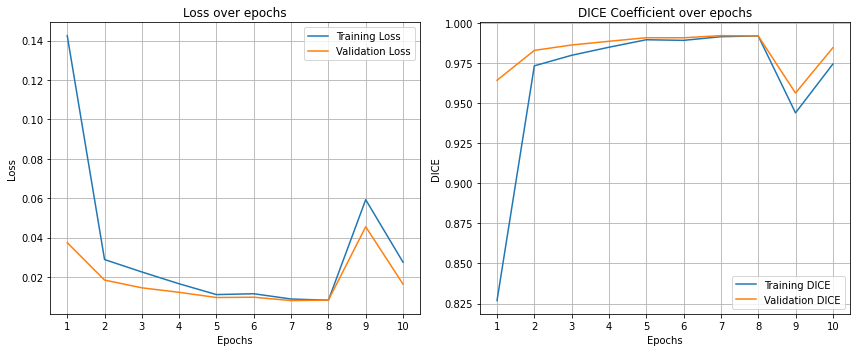

In [18]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))  
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


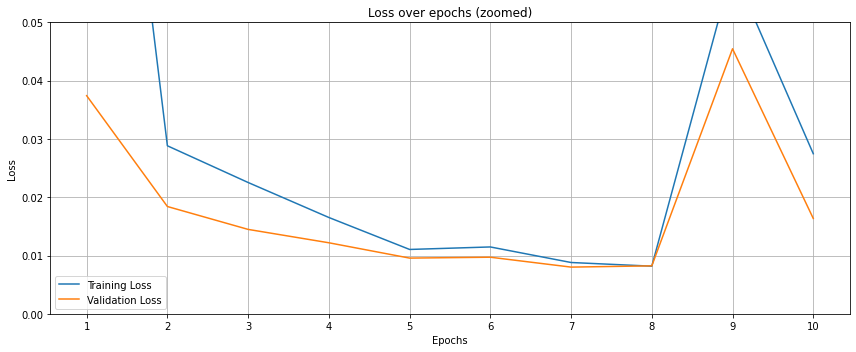

In [19]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.ylim(0, 0.05)
plt.title('Loss over epochs (zoomed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()
plt.show()



In [20]:
model_pth = '/kaggle/working/my_checkpoint.pth'
trained_model = UNet(in_channels=3, num_classes=1).to(device)
trained_model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

<All keys matched successfully>

In [21]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = trained_model(img)
        loss = criterion(y_pred, mask)
        dc = dice_coefficient(y_pred, mask)

        test_running_loss += loss.item()
        test_running_dc += dc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)


100%|██████████| 64/64 [00:25<00:00,  2.56it/s]


In [22]:
test_loss

0.016588360478635877

In [23]:
test_dc

0.9845270849764347

In [24]:
def random_images_inference(image_tensors, mask_tensors, image_paths, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Resize((512, 512))
    ])

    # Iterate for the images, masks and paths
    for image_pth, mask_pth, image_paths in zip(image_tensors, mask_tensors, image_paths):
        # Load the image
        img = transform(image_pth)
        
        # Predict the imagen with the model
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1,2,0)
        
        # Load the mask to compare
        mask = transform(mask_pth).permute(1, 2, 0).to(device)
        
        print(f"Image: {os.path.basename(image_paths)}, DICE coefficient: {round(float(dice_coefficient(pred_mask, mask)),5)}")
        
        # Show the images
        img = img.cpu().detach().permute(1, 2, 0)
        pred_mask = pred_mask.cpu().detach()
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1
        
        plt.figure(figsize=(15, 16))
        plt.subplot(131), plt.imshow(img), plt.title("original")
        plt.subplot(132), plt.imshow(pred_mask, cmap="gray"), plt.title("predicted")
        plt.subplot(133), plt.imshow(mask, cmap="gray"), plt.title("mask")
        plt.show()


In [25]:
n = 10 #10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(test_dataloader.dataset) - 1)
    random_sample = test_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2]) 



Image: 1e6f48393e17_12.jpg, DICE coefficient: 0.99006


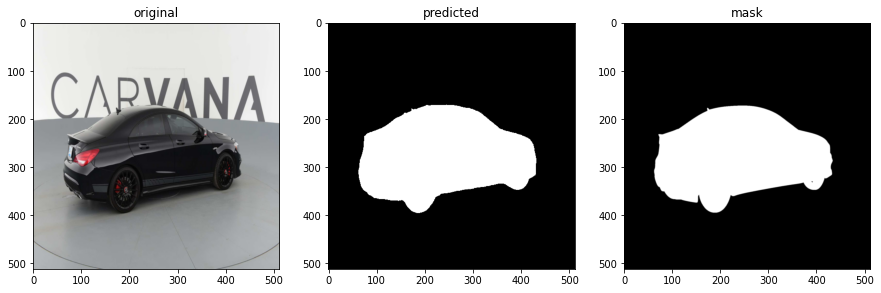

Image: 6bf969856536_01.jpg, DICE coefficient: 0.98459


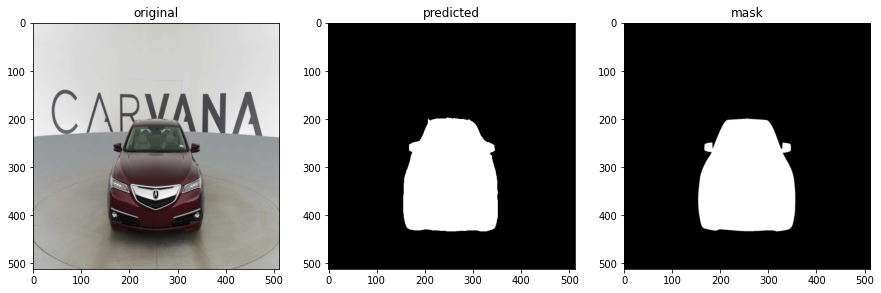

Image: 68fcee2be01f_14.jpg, DICE coefficient: 0.98379


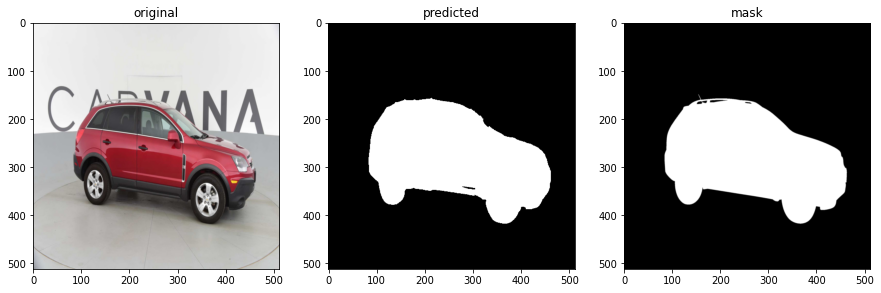

Image: b58cc561e560_03.jpg, DICE coefficient: 0.98675


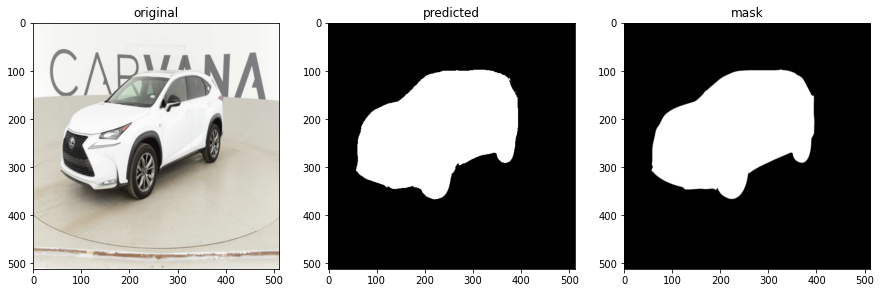

Image: 85bc655a7523_12.jpg, DICE coefficient: 0.98461


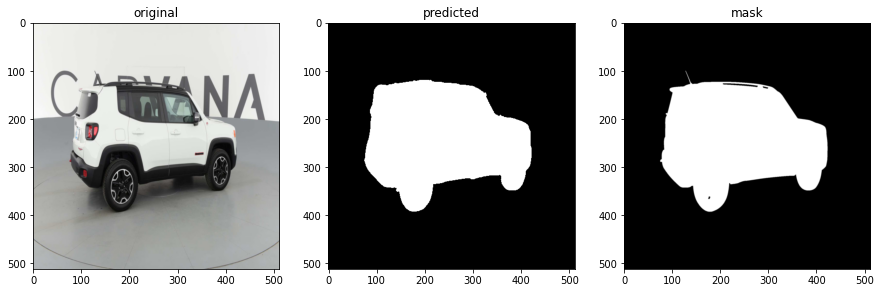

Image: f98dbe8a5ee2_10.jpg, DICE coefficient: 0.98923


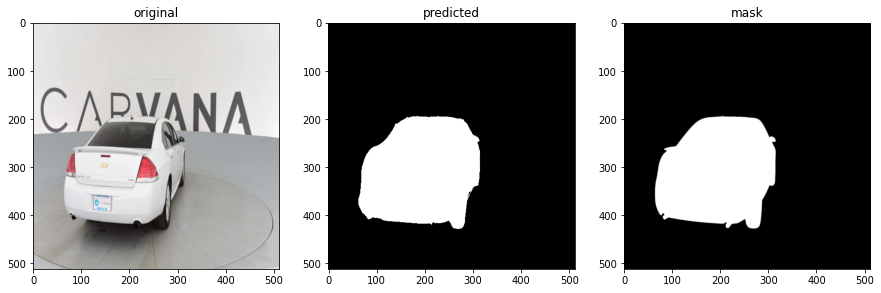

Image: 02159e548029_06.jpg, DICE coefficient: 0.98797


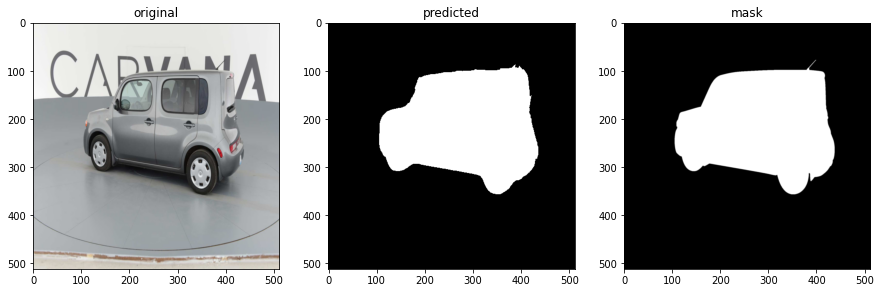

Image: 9274d0b3caa8_15.jpg, DICE coefficient: 0.98785


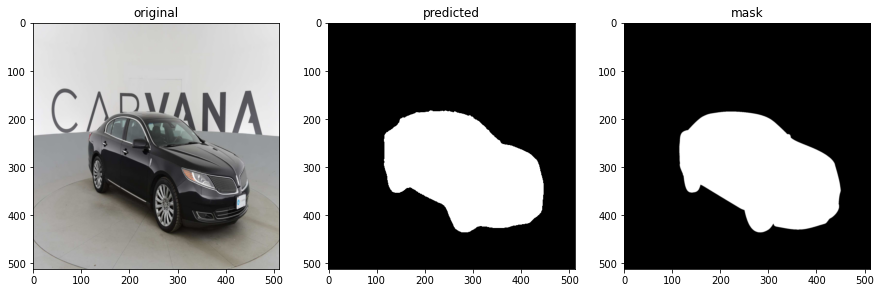

Image: bad53871c7d9_16.jpg, DICE coefficient: 0.98708


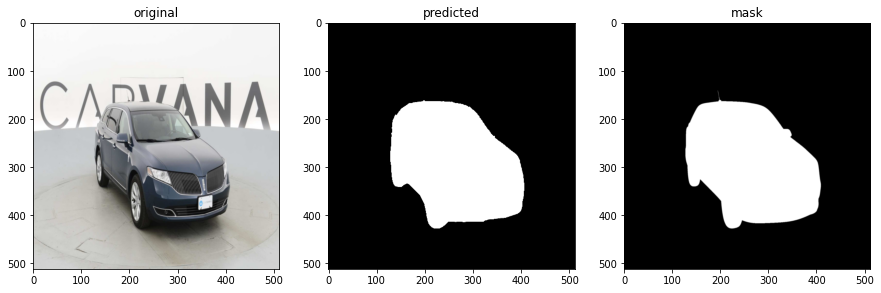

Image: 3f202616a2b9_13.jpg, DICE coefficient: 0.98794


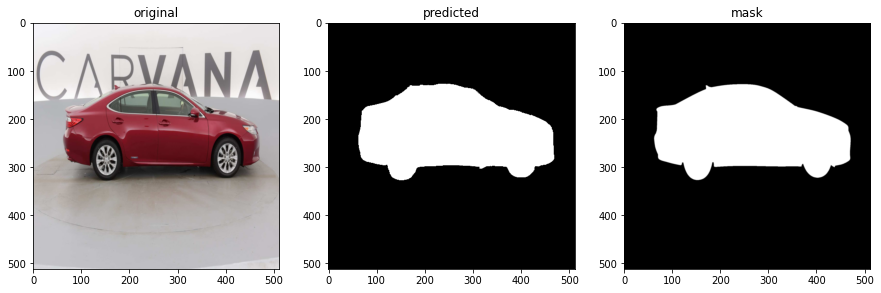

In [26]:
model_path = '/kaggle/working/my_checkpoint.pth'

random_images_inference(image_tensors, mask_tensors, image_paths, model_path, device="cpu")

# Optional: checking the masks in the training

Image: 562706000bd7_09.jpg, DICE coefficient: 0.97394


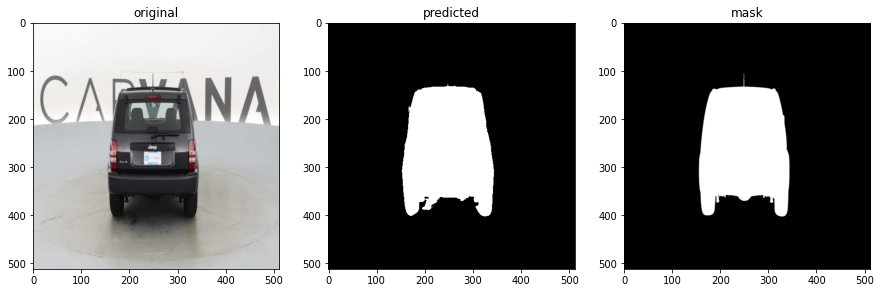

Image: 6cc98271f4dd_02.jpg, DICE coefficient: 0.98852


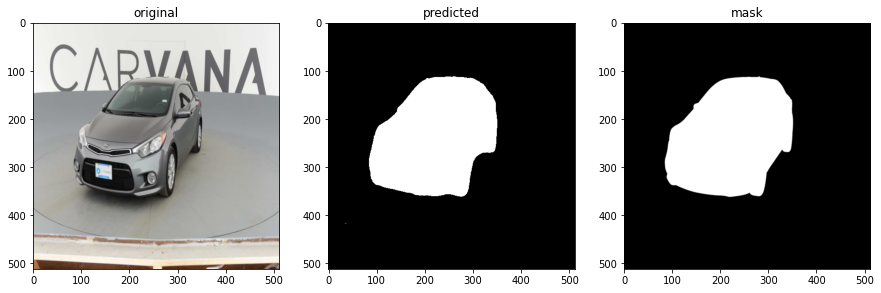

Image: c9acf5847ef1_16.jpg, DICE coefficient: 0.97064


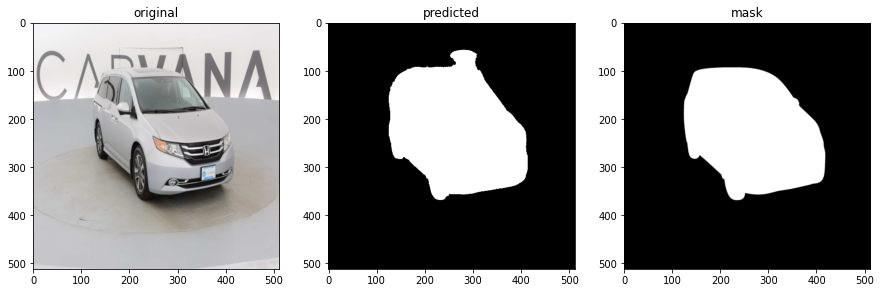

Image: cf65b1c5e147_02.jpg, DICE coefficient: 0.98949


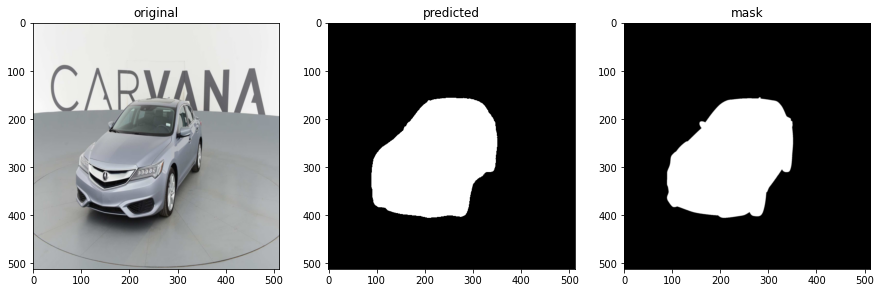

Image: c3dafdb02e7f_14.jpg, DICE coefficient: 0.98632


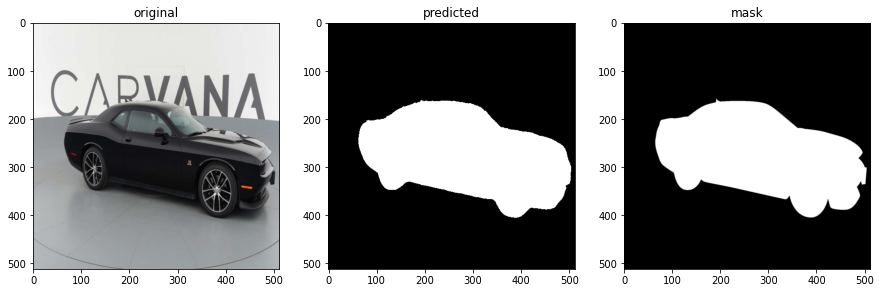

Image: 78bfb9c780db_06.jpg, DICE coefficient: 0.97575


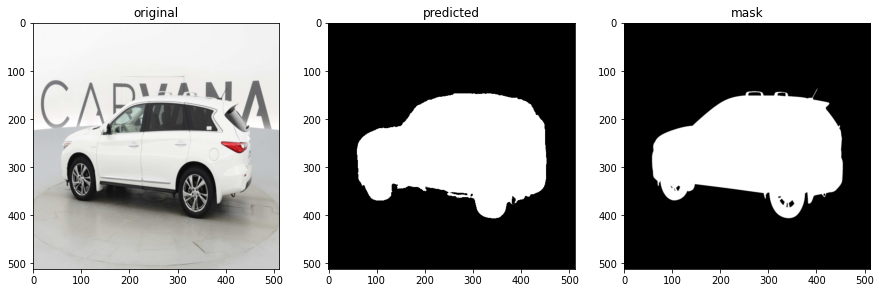

Image: 6ae670e86620_09.jpg, DICE coefficient: 0.97861


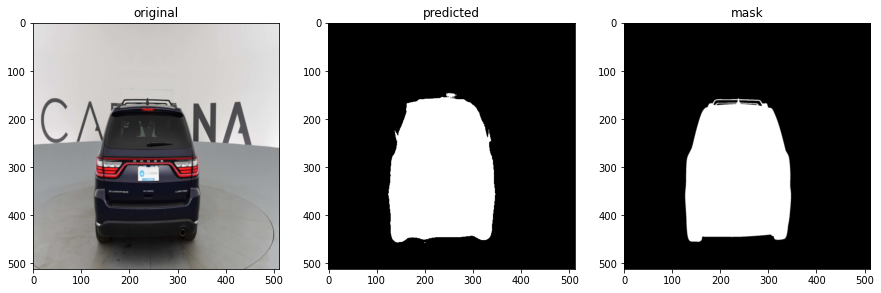

Image: f7ad86e13ed7_14.jpg, DICE coefficient: 0.9868


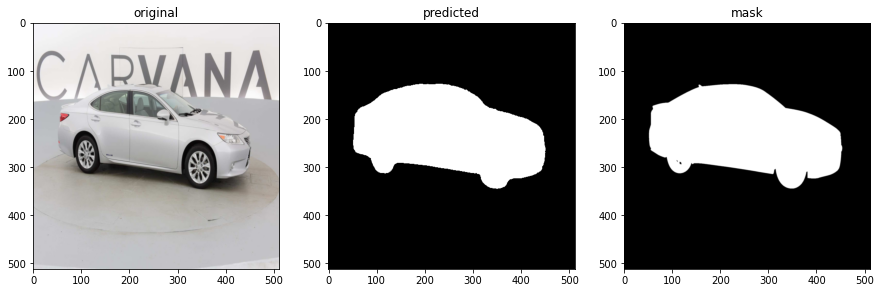

Image: 2a4a8964ebf3_02.jpg, DICE coefficient: 0.98574


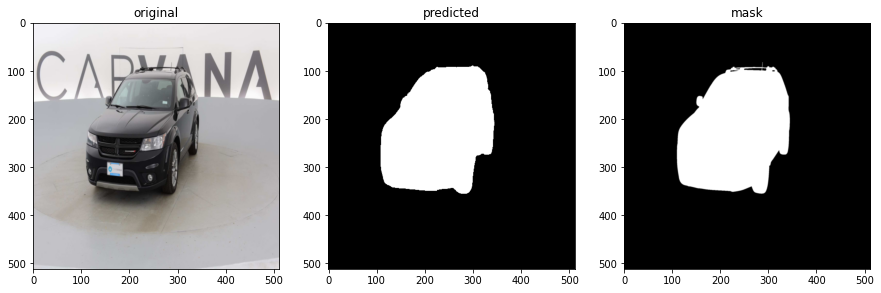

Image: fa613ac8eac5_11.jpg, DICE coefficient: 0.98895


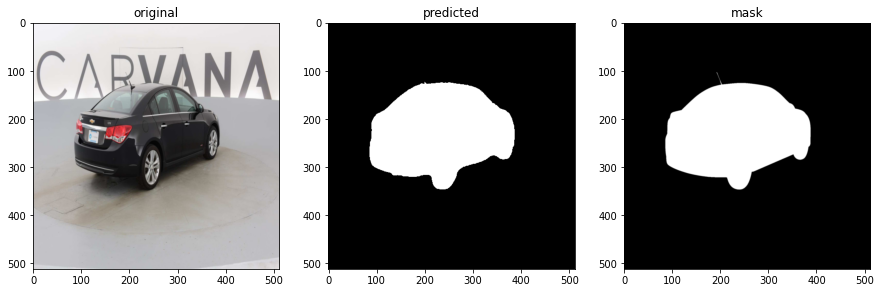

In [27]:
n = 10 # 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(train_dataloader.dataset) - 1)
    random_sample = train_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2]) 

random_images_inference(image_tensors, mask_tensors, image_paths, model_path, device="cpu")